In [60]:
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import os
from scipy.stats import norm

plt.style.use('Solarize_Light2')

### Constants

In [61]:
WINDOW = 21

n_ema_high = f"{WINDOW}-EMA_high"
n_ema_low = f"{WINDOW}-EMA_low"

### Loading data

In [62]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    gold_ticker = yf.Ticker("GC=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
df.columns = df.columns.str.lower()

# display(df.shape)
# display(df.head(3))

### Creating needed metrics

In [64]:
df[n_ema_high] = df['high'].ewm(span=WINDOW, adjust=False).mean()
df['extension_high'] = np.where(df['high'] > df[n_ema_high], df['high'] - df[n_ema_high], 0)

df[n_ema_low] = df['low'].ewm(span=WINDOW, adjust=False).mean()
df['extension_low'] = np.where(df['low'] < df[n_ema_low], df['low'] - df[n_ema_low], 0)

df.tail()

,open,high,low,close,21-EMA_high,extension_high,21-EMA_low,extension_low
Datetime,,,,,,,,
2024-09-30 13:00:00+00:00,2660.800049,2663.600098,2651.699951,2657.100098,2677.132229,0.0,2668.969542,-17.269591
2024-09-30 14:00:00+00:00,2657.000000,2657.899902,2650.199951,2655.000000,2675.383836,0.0,2667.263215,-17.063264
2024-09-30 15:00:00+00:00,2655.100098,2658.100098,2652.000000,2655.300049,2673.812587,0.0,2665.875650,-13.875650
2024-09-30 16:00:00+00:00,2655.500000,2661.000000,2654.899902,2660.800049,2672.647806,0.0,2664.877855,-9.977953
2024-09-30 17:00:00+00:00,2660.800049,2663.399902,2657.800049,2660.199951,2671.807088,0.0,2664.234418,-6.434369


### Looking for an Edge

In [65]:
df['extension_low'].agg(['max', 'min']).to_frame('range')

,range
max,0.000000
min,-62.087317


In [66]:
df['extension_high'].agg(['max', 'min']).to_frame('range')

,range
max,70.310872
min,0.000000


- Visualization

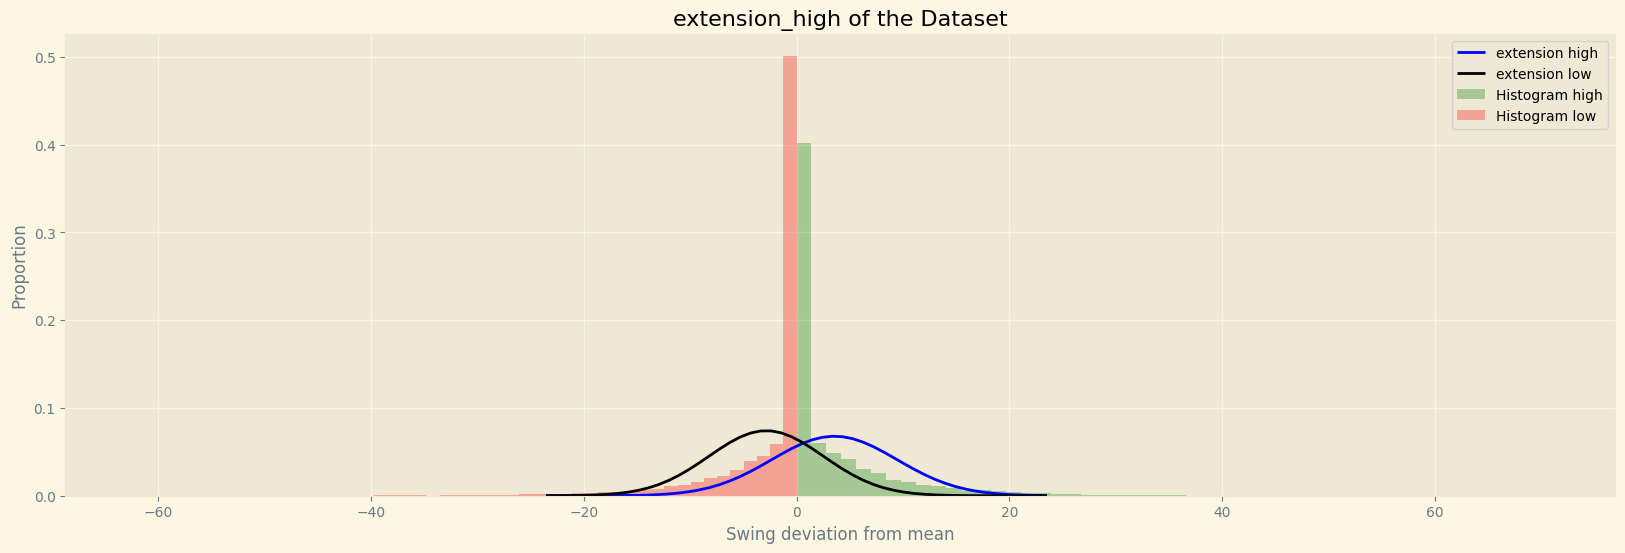

In [77]:
# Step 2: Calculate mean and standard deviation
mean_high, std_dev_high = df['extension_high'].mean(), df['extension_high'].std()
mean_low, std_dev_low = df['extension_low'].mean(), df['extension_low'].std()

std_dev = max(std_dev_high, std_dev_low)

n = 4

# Step 3: Generate x values for the extension
x = np.linspace(-n * std_dev, n * std_dev)
y_high = norm.pdf(x, mean_high, std_dev_high)
y_low = norm.pdf(x, mean_low, std_dev_low)

# Step 4: Plot the extension_high
plt.figure(figsize=(20, 6))

plt.plot(x, y_high, label='extension high', color='blue')
plt.plot(x, y_low, label='extension low', color='black')
plt.hist(df['extension_high'], bins=50, density=True, alpha=0.3, color='green', label='Histogram high')
plt.hist(df['extension_low'], bins=50, density=True, alpha=0.3, color='red', label='Histogram low')

plt.title('extension_high of the Dataset')
plt.xlabel('Swing deviation from mean')
plt.ylabel('Proportion')
plt.legend()
plt.show()